# FINAL PROJECT. Solution for complex business task. Creation of recommendation system for online courses for online college MasterMind.

## Project goal

Build course recommendation system by proposing similar courses by interests for increasing average income from customers.


## Tasks

1. Explore and analyse the dataset with SQL, and prepare data. 

2. Process the data with Python. 

3. Build summary table with recommendations, and provide arguments for conclusions.

### 1. SQL queries to explore the data
<div class="alert alert-block alert-info">
<pre>
<b>What is the year span in data?</b></div>
<div class="alert alert-block alert-success">

<pre>

SELECT 
    min(purchased_at),
    max(purchased_at)
FROM 
    final.carts
WHERE 
    state = 'successful'
 
<b>Answer:</b>  2017, 2018
</div>
<div class="alert alert-block alert-info">
<pre>
<b>How many customers bought courses?</b></div>

<div class="alert alert-block alert-success">

<pre>

SELECT 
    count(distinct(user_id))
FROM 
    final.carts c
JOIN 
    final.cart_items ci 
        ON c.id=ci.cart_id
WHERE 
    c.state='successful'
    AND ci.resource_type='Course'

<b>Answer:</b>  49006
</div>

<div class="alert alert-block alert-info">
<pre>
<b>How many courses in course list?</b></div>

<div class="alert alert-block alert-success">

<pre>

SELECT 
    count(distinct(resource_id))
FROM 
    final.cart_items
WHERE 
    resource_type='Course'

<b>Answer:</b>  127
</div>

<div class="alert alert-block alert-info">
<pre>
<b>How many courses bought in average by one customer?</b></div>

<div class="alert alert-block alert-success">

<pre>
SELECT 
    avg(course_num)
FROM
    (SELECT c.user_id,
          count(ci.resource_id) AS course_num
   FROM final.carts c
   JOIN final.cart_items ci ON c.id=ci.cart_id
   WHERE c.state='successful'
     AND ci.resource_type='Course'
   GROUP BY c.user_id) q1

<b>Answer:</b>  1.44
</div>
<div class="alert alert-block alert-info">
<pre>
<b>How many customers bought more than one course?</b></div>

<div class="alert alert-block alert-success">

<pre>
WITH users AS
    (SELECT c.user_id,
          count(ci.resource_id) AS course_num
    FROM final.carts c
    JOIN final.cart_items ci ON c.id=ci.cart_id
    WHERE c.state='successful'
        AND ci.resource_type='Course'
    GROUP BY c.user_id
    HAVING count(DISTINCT ci.resource_id)>1)
SELECT 
    count(DISTINCT(user_id))
FROM 
    users

<b>Answer:</b>  12656
</div>

### 2. Data processing with Python

In [1]:
import psycopg2
import psycopg2.extras
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# SQL query to get a relevant data about all users who bought more than one course, insert to python function

def getUsersBoughtMoreThanOneCourse():
    query = '''WITH DATA AS
      (SELECT DISTINCT user_id,
                       resource_id
       FROM final.carts AS c
       JOIN final.cart_items AS i ON c.id = i.cart_id
       WHERE state = 'successful'
         AND resource_type = 'Course'
       ORDER BY 1), counter AS
      (SELECT user_id,
              count(resource_id) AS cc
       FROM DATA
       GROUP BY user_id)
    SELECT c.user_id,
           d.resource_id
    FROM counter AS c
    JOIN DATA AS d ON c.user_id = d.user_id
    WHERE cc > 1
    ORDER BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

In [3]:
df = pd.DataFrame(getUsersBoughtMoreThanOneCourse())
df.head()

,user_id,resource_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125


In [4]:
# rename columns
df.columns = ['user', 'course']
df.head()

,user,course
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125


In [5]:
# find number of customers that bought more than one course
df.course.nunique()

126

In [6]:
# group courses by customer
group_df = df.groupby('user')['course'].apply(lambda x:list(np.unique(x))).reset_index()
group_df.head()

,user,course
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"


In [7]:
# check that minimal number of courses by customer is 2
group_df['course_cnt'] = group_df['course'].str.len()
group_df.sort_values(by='course_cnt')

,user,course,course_cnt
0,51,"[516, 1099]",2
8000,1147815,"[552, 829]",2
8001,1147943,"[551, 659]",2
8002,1147952,"[363, 566]",2
8005,1148026,"[569, 840]",2
...,...,...,...
5562,992470,"[489, 502, 514, 515, 517, 518, 519, 523, 551, ...",17
4072,722252,"[357, 366, 489, 490, 502, 514, 515, 523, 551, ...",17
6412,1050532,"[363, 366, 489, 502, 511, 523, 551, 552, 562, ...",18
5370,953401,"[490, 502, 514, 515, 518, 519, 523, 551, 552, ...",18


In [8]:
# list of courses bought together (pairs)
list_courses = list()
for course in group_df['course']:
    for pair in itertools.combinations(course,2):
        list_courses.append(pair)
len(list_courses)

40017

In [9]:
# total number of pairs
list_courses_set = set(list_courses)
len(list_courses_set)

3989

In [10]:
# most popular courses bought together
course_pairs = Counter(pair for pair in list_courses)
course_pairs.most_common(5)

[((551, 566), 797),
 ((515, 551), 417),
 ((489, 551), 311),
 ((523, 551), 304),
 ((566, 794), 290)]

### 3. Build total dataframe for recommendation system

In [11]:
# sort pairs by first course
sorted_pairs = {k: v for k, v in sorted(course_pairs.items(), key=lambda item: item[0], reverse=False)}
# unique course ids
courses = df['course'].unique()

In [12]:
# list of the most popular pair for each course
def recommend(course):
    course_list = []
    for i in sorted_pairs.keys():
        if i[0] == course:
            course_list.append((i, sorted_pairs[i]))  
    sorted_course_list = sorted(course_list, key=lambda x: x[1], reverse=True)
    return sorted_course_list[:2]   

recommend(864) # function test

[((864, 1125), 4), ((864, 1138), 3)]

In [13]:
# build table for courses and recommendations
recommend_df = pd.DataFrame(columns=['Recommendation 1', 'Recommendation 2'])
for i in courses:  
    if len(recommend(i)) == 2:  
        recommend_df.loc[i] = [recommend(i)[0][0][1], recommend(i)[1][0][1]]    
    elif len(recommend(i)) == 1:   
        recommend_df.loc[i] = [recommend(i)[0][0][1], np.nan] 
    else:
        recommend_df.loc[i] = [np.nan, np.nan]

recommend_df.tail(20)

,Recommendation 1,Recommendation 2
1145,1161,1156
1188,NaN,NaN
756,764,777
866,1103,1104
749,794,757
368,572,569
364,551,503
834,1102,1103
1152,1160.0,NaN
670,756,764


The result is a recommendation table based on courses popularity without minimum limit for frequency.

There are also no recommendations for infrequently purchased courses.

Let's study pair purchases number of courses depending on pair rating.

In [14]:
# build table with rating pair courses count
df_rating = pd.DataFrame.from_dict(course_pairs, orient='index').reset_index()
df_rating.columns = ['course_pair', 'rating']
df_rating.sort_values(by='rating',ascending=False).head()

,course_pair,rating
186,"(551, 566)",797
381,"(515, 551)",417
205,"(489, 551)",311
105,"(523, 551)",304
519,"(566, 794)",290


In [15]:
# group table by rating to show count of purchases for each rating
grouped_rating = df_rating.groupby('rating')['course_pair'].count().reset_index()
grouped_rating.columns = ['rating', 'purch_amount']
grouped_rating.head(10)

,rating,purch_amount
0,1,1185
1,2,578
2,3,366
3,4,259
4,5,202
5,6,148
6,7,148
7,8,95
8,9,80
9,10,87


Text(0, 0.5, 'Rating pair')

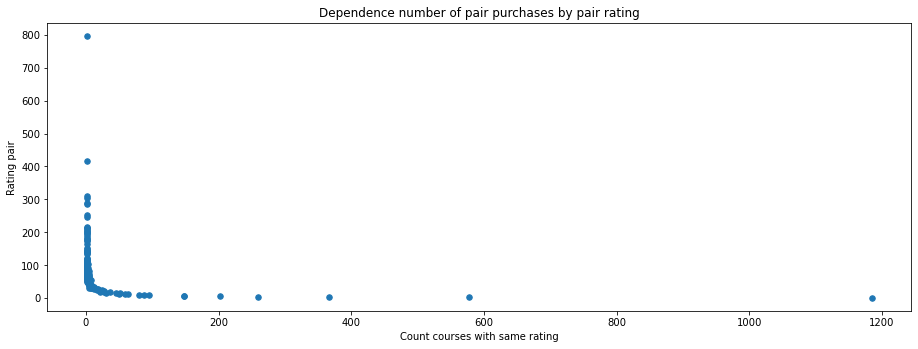

In [16]:
# build graph that shows dependence number of pair purchases by rating
fig = plt.figure(figsize=(12, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(grouped_rating['purch_amount'], grouped_rating['rating'],
    s=30,
    marker='o',
)
plt.title('Dependence number of pair purchases by pair rating')
plt.xlabel('Count courses with same rating')
plt.ylabel('Rating pair')

The graph shows that the highest density of purchases number is from 1 to 100. According to grouped_rating the exact value is 95 with rating 8. 

And this condition will be used for final recommendation dataframe.

Instead of less popular courses the pair with the highest rating will be used for recommendation.

In [17]:
# split most popular pair
popular_pair = df_rating.sort_values(by='rating',ascending=False).head(1).course_pair.tolist()
popular_course_1 = popular_pair[0][0]
popular_course_2 = popular_pair[0][1]
print(popular_course_1, popular_course_2)

551 566


In [18]:
# build final dataframe with course and 2 course recommendation for each course
fin_recommend_df = pd.DataFrame(columns=['Recommendation 1', 'Recommendation 2'])
for i in courses:   
    if len(recommend(i)) == 2 and recommend(i)[0][1] >= 8 and recommend(i)[1][1] >= 8: 
       
        fin_recommend_df.loc[i] = [recommend(i)[0][0][1], recommend(i)[1][0][1]]    
    elif len(recommend(i)) == 2 and recommend(i)[0][1] >= 8 and recommend(i)[1][1] < 8:
        
        fin_recommend_df.loc[i] = [recommend(i)[0][0][1], popular_course_1] 
        
    elif len(recommend(i)) == 2 and recommend(i)[0][1] < 8 and recommend(i)[1][1] < 8:
        
        fin_recommend_df.loc[i] = [popular_course_1, popular_course_2]
    elif len(recommend(i)) == 1 and recommend(i)[0][1] >= 8:    
        fin_recommend_df.loc[i] = [recommend(i)[0][0][1], popular_course_1] 
    else:
        fin_recommend_df.loc[i] = [popular_course_1, popular_course_2] 
        
fin_recommend_df=fin_recommend_df.reset_index()
fin_recommend_df=fin_recommend_df.rename(columns = {'index' : 'Course'})
fin_recommend_df

,Course,Recommendation 1,Recommendation 2
0,516,745,553
1,1099,1139,1187
2,356,571,357
3,357,571,1125
4,1125,1186,1144
...,...,...,...
121,902,551,566
122,837,551,566
123,1200,551,566
124,833,551,566


In [19]:
fin_recommend_df.to_csv('fin_recommend_df', encoding = 'utf8')

## In final table we can see two recommendations for each course according to purchases popularity.

## The table is stored in .csv format.